# The flexible interface

In the previous tutorial, we have demonstrated how `sbi` can be used to run simulation-based inference with just a single line of code.

In addition to this simple interface, `sbi` also provides a **flexible interface** which provides several additional features implemented in `sbi`.

Note, you find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Features

The flexible interface offers at least the following features:

- performing sequential posterior estimation by focusing on a particular observation over multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized ([tutorial](https://www.mackelab.org/sbi/tutorial/03_multiround_inference/)).    
- specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)) ([tutorial](https://www.mackelab.org/sbi/tutorial/04_density_estimators/)).    
- use an `embedding_net` to learn summary features from high-dimensional simulation outputs ([tutorial](https://www.mackelab.org/sbi/tutorial/05_embedding_net/)).  
- provide presimulated data  
- run simulations in batches, which can speed up simulations.  
- when it makes sense, choose between different methods to sample from the posterior.  
- use calibration kernels as proposed by [Lueckmann, Goncalves et al. 2017](https://arxiv.org/abs/1711.01861).

## Main syntax
The main syntax for the flexible interface was changed in `sbi` version 0.14.0 (see [Github](https://github.com/mackelab/sbi/pull/378) for details). Below, we show the syntax of the flexible interface until and after v0.13.2.

### Syntax until v0.13.2

In [ ]:
from sbi.inference import SNPE, prepare_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(simulator, prior)

# Simulate, train, and build posterior.
posterior = inference(num_simulation=1000)

### Syntax from v0.14.0 onwards

In [ ]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

## Linear Gaussian example

We will show an example of how we can use the flexible interface (v0.14.0 onwards) to infer the posterior for an example with a Gaussian likelihood (same example as before). First, we import the inference method we want to use (`SNPE`, `SNLE`, or `SNRE`) and other helper functions.

In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

Next, we define the prior and simulator:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In the flexible interface, you have to ensure that your simulator and prior adhere the requirements of `sbi`. You can do so with the `prepare_for_sbi()` function.

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Then, we instantiate the inference object:

In [5]:
inference = SNPE(prior=prior)

Next, we run simulations. You can do so either by yourself by sampling from the prior and running the simulator (e.g. on a compute cluster), or you can use a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize your code with `joblib`.

In [6]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=500)

We then pass the simulated data to the inference object. `theta` and `x` should both be tensors of type float32.

In [7]:
inference = inference.append_simulations(theta, x)

Next, we train the neural density estimator.

In [8]:
density_estimator = inference.train()

Neural network successfully converged after 191 epochs.


Lastly, we can use this density estimator to build the posterior:

In [9]:
posterior = inference.build_posterior(density_estimator)

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

In [10]:
x_o = torch.zeros(3,)

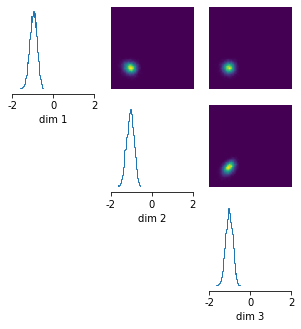

In [11]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

We can always print the posterior to know how it was trained:

In [12]:
print(posterior)

Posterior conditional density p(θ|x) (amortized).

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.
